In [3]:
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
from fastai.callback.hook import ActivationStats
from fastai.vision.all import (
    accuracy,
    get_image_files,
    first,
    parent_label,
    to_cpu,
    sequential,
    untar_data,
    CategoryBlock,
    DataBlock,
    F,
    Flatten,
    GrandparentSplitter,
    ImageBlock,
    Normalize,
    Learner,
    Path,
    PILImageBW,
    URLs,
)
from fastai.vision.widgets import Image
from fastbook import show_image, image_bear, subplots
from torch import tensor, nn

## Our first Convolutional Neural Network

There is no reason to believe that some particular edge filters are the most useful kernels for image recognition. Furthermore, we've seen that in later layers convolutional kernels become complex transformations of features from lower levels, but we don't have a good idea of how to manually construct these.

It would be cool to learn the values of the kernels. We already know how to do this—SGD!

### Load dataset

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path


mnist = DataBlock(
    (ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,  # callable
    splitter=GrandparentSplitter(),
    get_y=parent_label # callable
)

dls = mnist.dataloaders(path)

xb, yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

### Creating the CNN

Possible architecture

In [5]:
broken_cnn = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=30, out_channels=1, kernel_size=3, padding=1)
)

broken_cnn

Sequential(
  (0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(30, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [6]:
# what will it be the shape of the output?
# remember, xb is the first batch of 64 items

broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

Okay, we are getting the same size of the input, and that's expected. But if we want to do classification, we need to downside the input to...1?
Maybe, we can try use stride-2 for several conv layers until we get the size of 1.

In [7]:
def conv(in_channels: int, out_channels: int, ks: int = 3, act: bool = True):
    res = nn.Conv2d(in_channels, out_channels, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [8]:
simple_cnn = sequential(
    conv(1, 4),            #14x14 - size of the activation map after this conv layer
    conv(4, 8),            #7x7
    conv(8, 16),           #4x4
    conv(16, 32),           #2x2
    conv(32, 2, act=False), #1x1
    Flatten(),
)

simple_cnn

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(32, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): fastai.layers.Flatten(full=False)
)

In [9]:
# Now the network outputs two activations, which map to the two possible levels in our labels:

simple_cnn(xb).shape

torch.Size([64, 2])

In [10]:
# now we can create our Learner

learner = Learner(
    dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy
)

In [11]:
learner.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

Note that the output of the final Conv2d layer is 64x2x1x1. We need to remove those extra 1x1 axes; that's what Flatten does. It's basically the same as PyTorch's squeeze method, but as a module.

In [ ]:
??learner.fit_one_cycle

In [12]:
# TRAINING
epochs = 2
lr = 0.01 # 1e-2

learner.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.074444,0.044515,0.985770,00:15
1,0.026935,0.030599,0.991168,00:15


### Understanding Convolution Arithmetic

We have an input of size 64x1x28x28. The axes are batch,channel,height,width. This is often represented as NCHW (where N refers to batch size).

In [14]:
# So we have 1 input channel, 4 output channels, and a 3×3 kernel, 4 filters of 3x3, 36 params (+4 by bias).

first_layer = learner.model[0]
first_layer

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [15]:
# checking the weights of the first conv layer

# 4 filters for black and white images of 3x3
first_layer[0].weight.shape

torch.Size([4, 1, 3, 3])

The summary indicates that there are 40 params, but here we only have `4*1*3*3 = 36`, the other ones are from the bias.

In [16]:
first_layer[0].bias.shape

torch.Size([4])

In [17]:
first_layer[0].weight, first_layer[0].bias

(Parameter containing:
 tensor([[[[ 0.2939,  0.3929,  0.0684],
           [ 0.0687,  0.2864, -0.0795],
           [-0.0894,  0.1612, -0.3944]]],
 
 
         [[[ 0.1311,  0.3753,  0.1348],
           [ 0.4136,  0.1383,  0.2391],
           [ 0.2486,  0.2967,  0.3317]]],
 
 
         [[[ 0.1632, -0.1358,  0.2403],
           [-0.1745, -0.0082,  0.2605],
           [-0.4919,  0.3294,  0.2497]]],
 
 
         [[[-0.1036,  0.2179, -0.2435],
           [-0.1119, -0.1284, -0.3055],
           [-0.1964, -0.0310,  0.2372]]]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2844,  0.1054, -0.1229, -0.2417], requires_grad=True))

Let's apply those learned filters to some image

In [18]:
tmp_kernels = first_layer[0].weight


batch_features = torch.nn.functional.conv2d(xb, tmp_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

<Axes: >

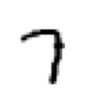

In [19]:
show_image(xb[0], cmap="Greys")

<Axes: title={'center': 'fourht filter'}>

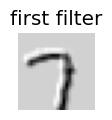

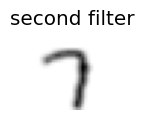

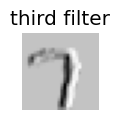

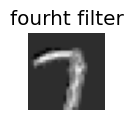

In [20]:
show_image(batch_features[0, 0], cmap="Greys", title="first filter")
show_image(batch_features[0, 1], cmap="Greys", title="second filter")
show_image(batch_features[0, 2], cmap="Greys", title="third filter")
show_image(batch_features[0, 3], cmap="Greys", title="fourht filter")

Checking the summary again...



What happened that is that our stride-2 convolution halved the grid size from 14x14 to 7x7, and we doubled the number of filters from 8 to 16, resulting in no overall change in the amount of computation. If we left the number of channels the same in each stride-2 layer, the amount of computation being done in the net would get less and less as it gets deeper. But we know that the deeper layers have to compute semantically rich features (such as eyes or fur), so we wouldn't expect that doing less computation would make sense.

### Receptive Fields

The receptive field is the area of an image that is involved in the calculation of a layer.


![](images/receptive_fields.png)


In this example, we have just two convolutional layers, each of stride 2, so this is now tracing right back to the input image. We can see that a 7×7 area of cells in the input layer is used to calculate the single green cell in the Conv2 layer. This 7×7 area is the receptive field in the input of the green activation in Conv2.


A large receptive field means that a large amount of the input image is used to calculate each activation in that layer is. We now know that in the deeper layers of the network we have semantically rich features, corresponding to larger receptive fields. Therefore, we'd expect that we'd need more weights for each of our features to handle this increasing complexity.

### Color images

A color picture is a rank-3 tensor

In [21]:
to_tensor_fn = transforms.ToTensor()

img = to_tensor_fn(Image.open(image_bear()))
img.shape

torch.Size([3, 1000, 846])

<Axes: >

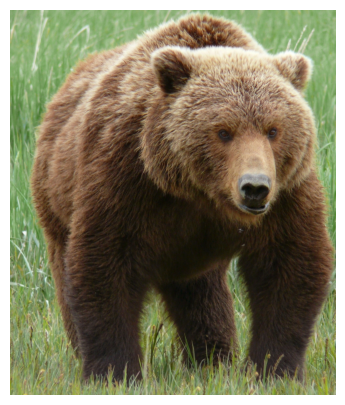

In [22]:
show_image(img)

The first axis contains the channels, red, green, and blue:

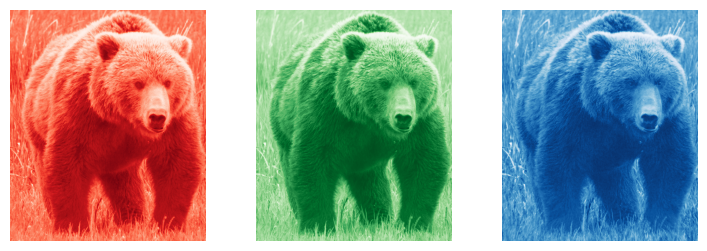

In [23]:
_,axs = subplots(1,3)
for bear,ax,color in zip(img, axs, ('Reds','Greens','Blues')):
    show_image(255-bear, ax=ax, cmap=color)

A convolutional layer will take an image with a certain number of channels (three for the first layer for regular RGB color images) and output an image with a different number of channels.

In one sliding window, we have a certain number of channels and we need as many filters. We multiply the elements of our window by the elements of the coresponding filter, then sum the results and sum over all the filters.

So, in order to apply a convolution to a color picture we require a kernel tensor with a size that matches the first axis. At each location, the corresponding parts of the kernel and the image patch are multiplied together.

These are then all added together, to produce a single number, for each grid location, for each output feature.


![](images/rgb_conv_stack.svg)

Then we have `ch_out` filters like this, so in the end, the result of our convolutional layer will be a batch of images with `ch_out` channels and a height and width given by the formula outlined earlier. This give us `ch_out` tensors of size `ch_in x ks x ks` that we represent in one big tensor of four dimensions. In PyTorch, the order of the dimensions for those weights is `ch_out x ch_in x ks x ks`.

Additionally, we may want to have a bias for each filter.

There are no special mechanisms required when setting up a CNN for training with color images. Just make sure your first layer has three inputs.

### Improving Training Stability

In [24]:
# use full MNIST

path = untar_data(URLs.MNIST)
Path.BASE_PATH = path

path.ls()

(#2) [Path('testing'),Path('training')]

In [25]:
!find $path/training -type f | wc -l
!find $path/testing -type f | wc -l

60000
10000


The data is in two folders named training and testing, so we have to tell GrandparentSplitter about that (it defaults to train and valid). We did do that in the get_dls function, which we create to make it easy to change our batch size later.

In [26]:
def get_dls(batch_size=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=batch_size)

dls = get_dls()

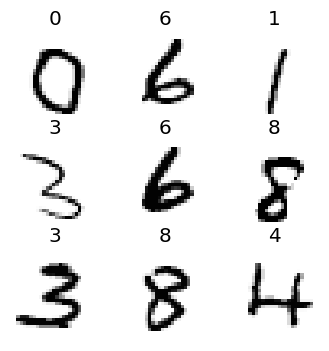

In [27]:
dls.show_batch(max_n=9, figsize=(4,4))

#### A Simple Baseline


Let's start with a basic CNN as a baseline. We'll use the same one as earlier, but with one tweak: we'll use more activations. Since we have more numbers to differentiate, it's likely we will need to learn more filters.


We generally want to double the number of filters each time we have a stride-2 layer. One way to increase the number of filters throughout our network is to double the number of activations in the first layer–then every layer after that will end up twice as big as in the previous version as well.

But there is a subtle problem with this. Consider the kernel that is being applied to each pixel. By default, we use a 3×3-pixel kernel. That means that there are a total of 3×3 = 9 pixels that the kernel is being applied to at each location. Previously, our first layer had four output filters. That meant that there were four values being computed from nine pixels at each location.

Think about what happens if we double this output to eight filters. Then when we apply our kernel we will be using nine pixels to calculate eight numbers. That means it isn't really learning much at all: the output size is almost the same as the input size. Neural networks will only create useful features if they're forced to do so—that is, **if the number of outputs from an operation is significantly smaller than the number of inputs.**

To fix this, we can use a larger kernel in the first layer. If we use a kernel of 5×5 pixels then there are 25 pixels being used at each kernel application. Creating eight filters from this will mean the neural net will have to find some useful features:

In [28]:
def simple_cnn():
    return sequential(
        conv(1, 8, ks=5),        #14x14
        conv(8, 16),             #7x7
        conv(16, 32),             #4x4
        conv(32, 64),             #2x2
        conv(64, 10, act=False),  #1x1
        Flatten(),
    )

As you'll see in a moment, we can look inside our models while they're training in order to try to find ways to make them train better. To do this we use the `ActivationStats` callback, which records the mean, standard deviation, and histogram of activations of every trainable layer.

In [29]:
def fit(epochs=1, lr=0.06):
    learn = Learner(
        dls,
        simple_cnn(),
        loss_func=F.cross_entropy,
        metrics=accuracy,
        cbs=ActivationStats(with_hist=True)
    )
    learn.fit(epochs, lr)

    return learn

In [30]:
learner = fit()

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.305526,2.307593,0.101000,01:26


It isn't a good accuracy.

ActivationStats includes some handy utilities for plotting the activations during training. plot_layer_stats(idx) plots the mean and standard deviation of the activations of layer number idx, along with the percentage of activations near zero.

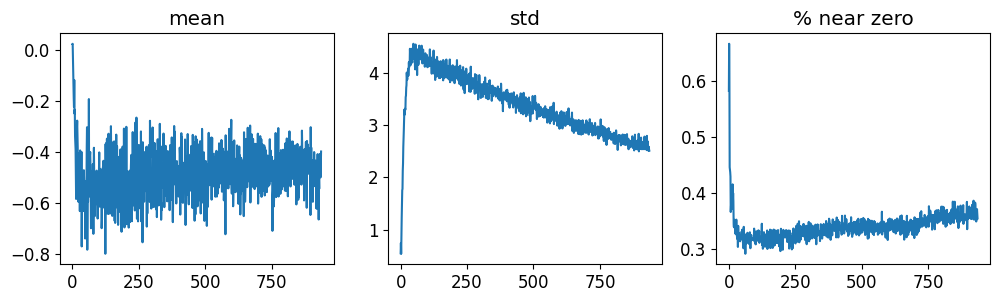

In [31]:
learner.activation_stats.plot_layer_stats(0)

There are 60k images for training, so since the batch size is 64, then there are around 900 batches, so that's the x-axis labels.

The mean of the values did keep stable, the standard deviation decreased and the % of activations with values near zero ended up high (38%), the last part is a smell that something could be better.

Generally our model should have a consistent, or at least smooth, mean and standard deviation of layer activations during training.

Activations near zero are particularly problematic, because it means we have computation in the model that's doing nothing at all (since multiplying by zero gives zero). When you have some zeros in one layer, they will therefore generally carry over to the next layer... which will then create more zeros. Here's the penultimate layer of our network:

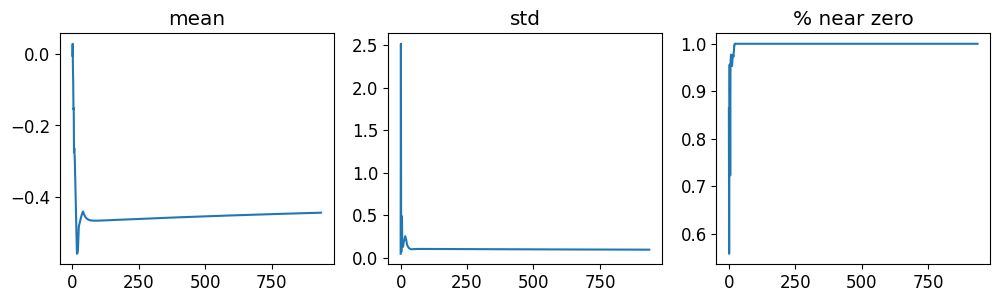

In [32]:
learner.activation_stats.plot_layer_stats(-2)

As expected, the problems get worse towards the end of the network, as the instability and zero activations compound over layers.

#### Increase Batch Size

One way to make training more stable is to increase the batch size. Larger batches have gradients that are more accurate, since they're calculated from more data. On the downside, though, a larger batch size means fewer batches per epoch, which means less opportunities for your model to update weights.

In [33]:
dls = get_dls(batch_size=512)

In [34]:
learner = fit() # the accucary is not good at all yet

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.305798,2.301943,0.113500,01:23


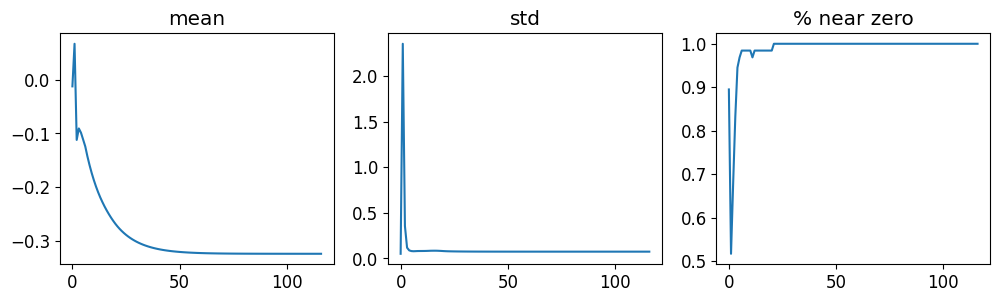

In [35]:
learner.activation_stats.plot_layer_stats(-2) # a bit better but not enough

### 1cycle Training

Our initial weights are not well suited to the task we're trying to solve. Therefore, it is dangerous to begin training with a high learning rate: we may very well make the training diverge instantly.

We should change the learning rate during training, from low, to high (the speed up training), and then back to low again.

...Leslie Smith (yes, the same guy that invented the learning rate finder!) developed that idea.


He designed a schedule for learning rate separated into two phases: one where the learning rate grows from the minimum value to the maximum value (warmup), and one where it decreases back to the minimum value (annealing). Smith called this combination of approaches **1cycle training**.

1cycle training  gives two benefits:

- By training with higher learning rates, we train faster—a phenomenon Smith named super-convergence.
- By training with higher learning rates, we overfit less because we skip over the sharp local minima to end up in a smoother (and therefore more generalizable) part of the loss.


Many researchers have found that in practice this approach leads to more accurate models and trains more quickly. That is why it is the approach that is used by default for fine_tune in fastai.

 Briefly, momentum is a technique where the optimizer takes a step not only in the direction of the gradients, but also that continues in the direction of previous steps. Leslie Smith introduced the idea of cyclical momentums. It suggests that the momentum varies in the opposite direction of the learning rate: when we are at high learning rates, we use less momentum, and we use more again in the annealing phase.

In [36]:
def fit(epochs=1, lr=0.06):
    learn = Learner(
        dls,
        simple_cnn(),
        loss_func=F.cross_entropy,
        metrics=accuracy,
        cbs=ActivationStats(with_hist=True)
    )
    learn.fit_one_cycle(epochs, lr)
    return learn

In [37]:
learner = fit()

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.196301,0.072730,0.977400,01:17


We're finally making some progress! It's giving us a reasonable accuracy now.

We can view the learning rate and momentum throughout training by calling `plot_sched` on `learn.recorder`. `learn.recorder` records everything that happens during training, including losses, metrics, and hyperparameters such as learning rate and momentum:

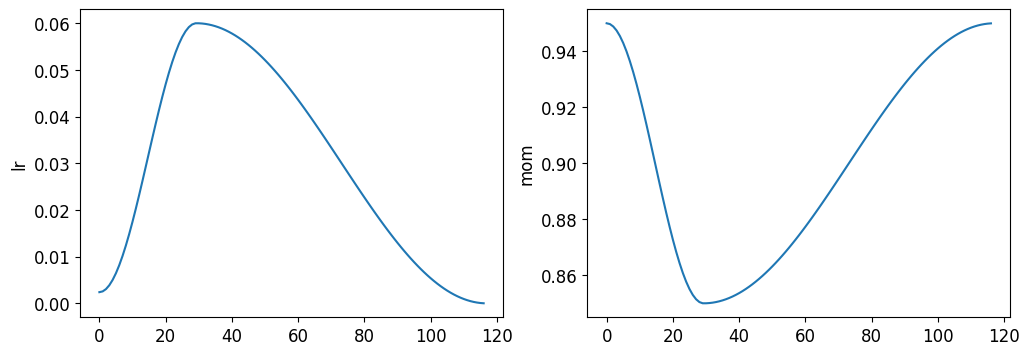

In [38]:
learner.recorder.plot_sched()

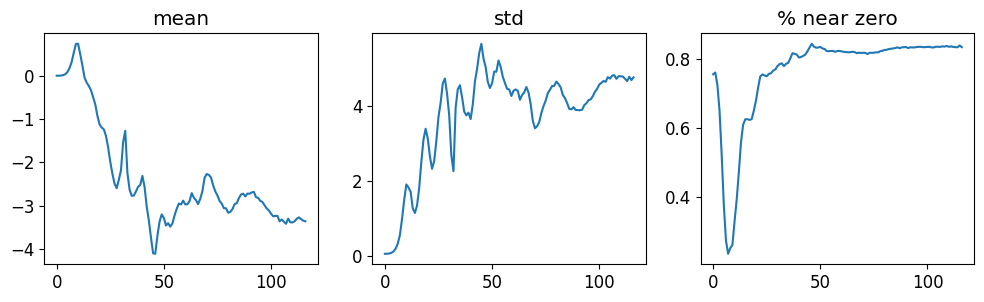

In [39]:
learner.activation_stats.plot_layer_stats(-2)

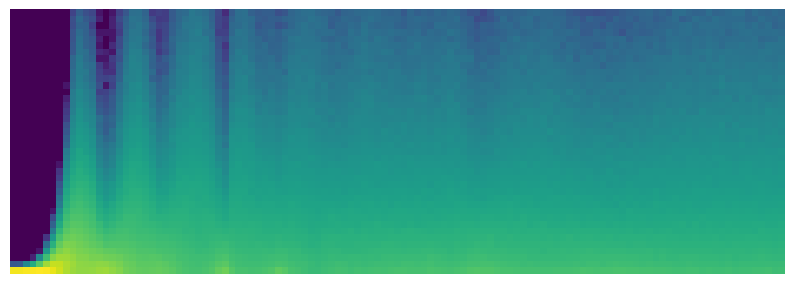

In [40]:
# We can see even more about what's going on in our training using color_dim, passing it a layer index:
learner.activation_stats.color_dim(-2)

This shows a classic picture of "bad training." We start with nearly all activations at zero—that's what we see at the far left, with all the dark blue. The bright yellow at the bottom represents the near-zero activations. Then, over the first few batches we see the number of nonzero activations exponentially increasing.

It's much better if training can be smooth from the start. The cycles of exponential increase and then collapse tend to result in a lot of near-zero activations, resulting in slow training and poor final results. One way to solve this problem is to use batch normalization.

####Batch normalization


We need to fix the initial large percentage of near-zero activations, and then try to maintain a good distribution of activations throughout training.


Sergey Ioffe and Christian Szegedy presented a solution to this problem in the 2015 paper "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift". In the abstract, they describe just the problem:

*Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization... We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.*

Their solution:

*Making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization.*

--------

Batch normalization (batchnorm) works by taking an average of the mean and standard deviations of the activations of a layer and using those to normalize the activations. However, this can cause problems because the network might want some activations to be really high in order to make accurate predictions. So they also added two learnable parameters (they will be updated in the SGD step), usually called `gamma` and `beta`. After normalizing the activations to get some new activation vector `y`, a batchnorm layer returns `gamma*y + beta`.

In [41]:
# let's add a batchnorm to conv

def conv(in_channels: int, out_channels: int, ks=3, act=True):
    layers = [
        nn.Conv2d(in_channels, out_channels, stride=2, kernel_size=ks, padding=ks//2)
    ]

    if act:
        layers.append(nn.ReLU())

    layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [42]:
learner = fit()

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.130691,0.058669,0.985000,01:24


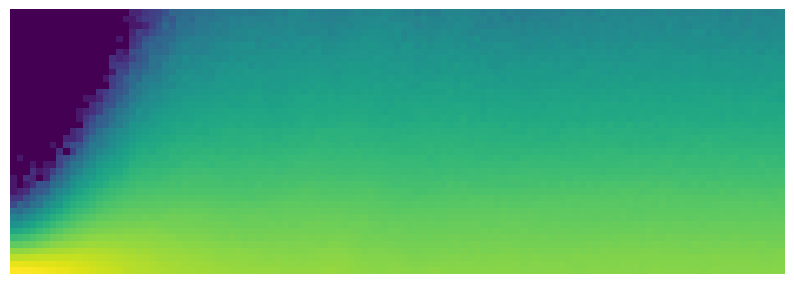

In [43]:
learner.activation_stats.color_dim(-4)

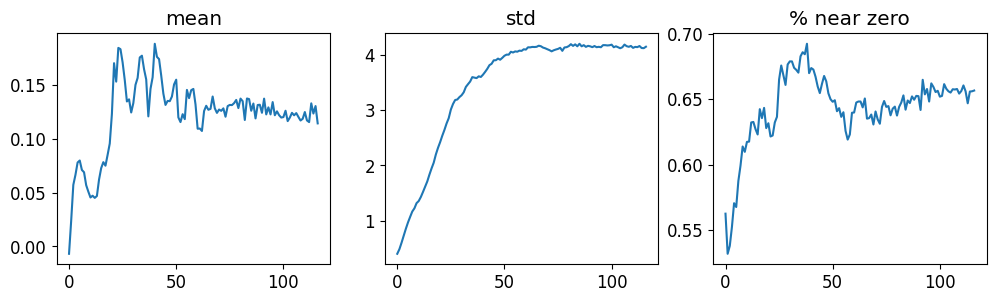

In [44]:
learner.activation_stats.plot_layer_stats(-2)

This is just what we hope to see: a smooth development of activations, with no "crashes." Batchnorm has really delivered on its promise here! In fact, batchnorm has been so successful that we see it (or something very similar) in nearly all modern neural networks.

An interesting observation about models containing batch normalization layers is that they tend to generalize better than models that don't contain them. Although we haven't as yet seen a rigorous analysis of what's going on here, most researchers believe that the reason for this is that batch normalization adds some extra randomness to the training process. Each mini-batch will have a somewhat different mean and standard deviation than other mini-batches.


-----
Since things are going so well, let's train for a few more epochs and see how it goes. In fact, let's increase the learning rate, since the abstract of the batchnorm paper claimed we should be able to "train at much higher learning rates".


In [45]:
learner = fit(epochs=5, lr=0.1)

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.172731,0.103205,0.968200,01:20
1,0.079107,0.053262,0.982700,01:21
2,0.049122,0.037133,0.987800,01:20
3,0.030852,0.027315,0.991800,01:19
4,0.015546,0.022354,0.992100,01:20


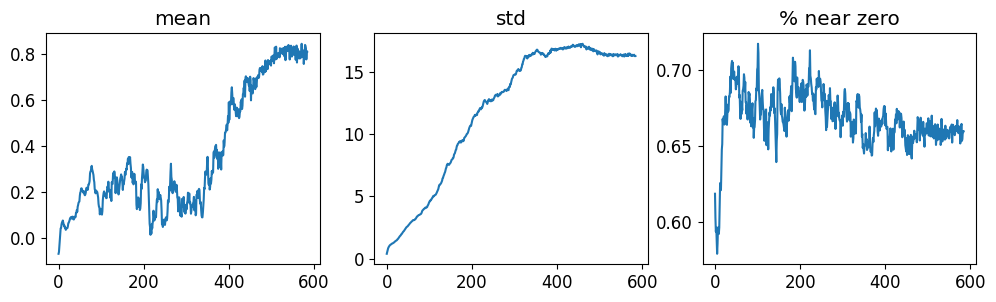

In [46]:
learner.activation_stats.plot_layer_stats(-2)

We can notice stability at the end (last epoch) that's a good signal.